/home/vantuan_ngo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:13<00:00, 721kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 31.8kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:07<00:00, 219kB/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.22MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/10], Loss: 0.0100
Epoch [2/10], Loss: 0.0098
Epoch [3/10], Loss: 0.0098
Epoch [4/10], Loss: 0.0098
Epoch [5/10], Loss: 0.0098
Epoch [6/10], Loss: 0.0098
Epoch [7/10], Loss: 0.0098
Epoch [8/10], Loss: 0.0098
Epoch [9/10], Loss: 0.0098
Epoch [10/10], Loss: 0.0098


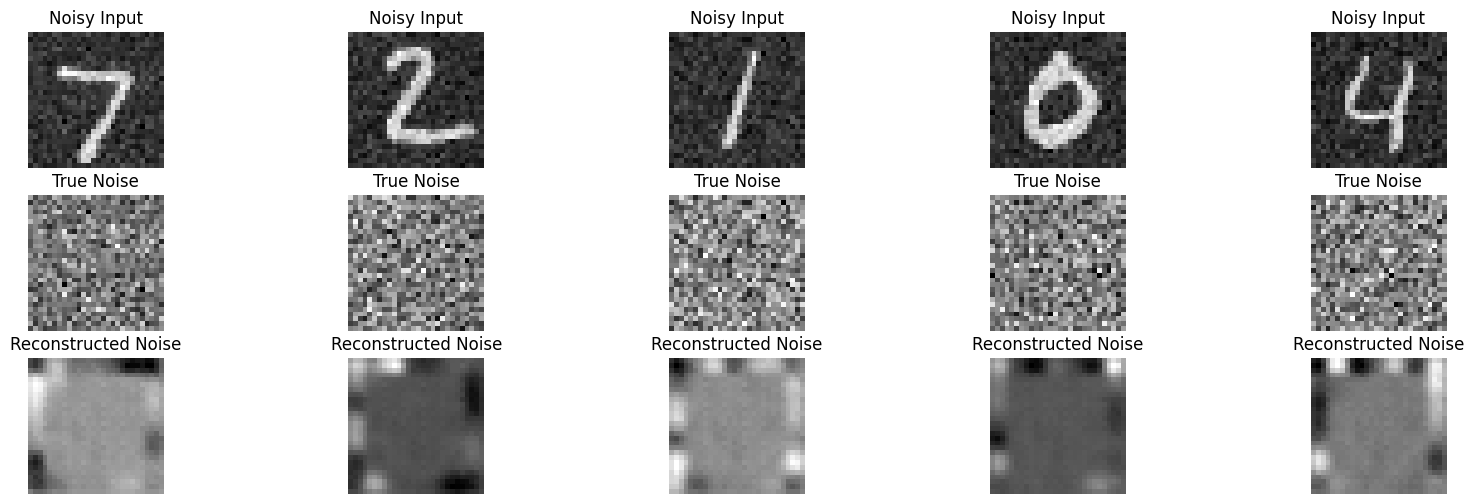

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Function to add Gaussian noise
def add_gaussian_noise(data, mean=0.0, std=0.1):
    noise = torch.normal(mean=mean, std=std, size=data.shape).to(data.device)
    noisy_data = data + noise
    return noisy_data, noise

# Define the Autoencoder
class NoiseAutoencoder(nn.Module):
    def __init__(self):
        super(NoiseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Latent space
        self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 64 * 7 * 7)
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Identity()  # Linear output for noise (no activation)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = x.view(-1, 64, 7, 7)
        x = self.decoder(x)
        return x

# Initialize model, loss, and optimizer
model = NoiseAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        
        # Add Gaussian noise
        noisy_images, noise = add_gaussian_noise(images, mean=0.0, std=0.1)
        
        # Forward pass
        outputs = model(noisy_images)
        loss = criterion(outputs, noise)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Testing and visualization
model.eval()
with torch.no_grad():
    # Get some test images
    test_images, _ = next(iter(test_loader))
    test_images = test_images[:5].to(device)
    noisy_images, true_noise = add_gaussian_noise(test_images, mean=0.0, std=0.1)
    reconstructed_noise = model(noisy_images)
    
    # Move to CPU for visualization
    noisy_images = noisy_images.cpu().numpy()
    true_noise = true_noise.cpu().numpy()
    reconstructed_noise = reconstructed_noise.cpu().numpy()
    
    # Visualize results
    plt.figure(figsize=(20, 6))
    for i in range(5):
        # Noisy input
        plt.subplot(3, 5, i + 1)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        plt.title('Noisy Input')
        plt.axis('off')
        
        # True noise
        plt.subplot(3, 5, i + 6)
        plt.imshow(true_noise[i].squeeze(), cmap='gray')
        plt.title('True Noise')
        plt.axis('off')
        
        # Reconstructed noise
        plt.subplot(3, 5, i + 11)
        plt.imshow(reconstructed_noise[i].squeeze(), cmap='gray')
        plt.title('Reconstructed Noise')
        plt.axis('off')
    plt.show()